### 0. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

plt.style.use('seaborn-v0_8-whitegrid')

### 1. Load Processed Data
We load the feature-engineered datasets created in the previous step. This ensures we are using exactly the same data (scaled, smoothed, and with interaction terms) for all model comparisons.

In [ ]:
# Load datasets
data_dir = '../data/processed'
train_df = pd.read_csv(f'{data_dir}/train_featured.csv')
val_df = pd.read_csv(f'{data_dir}/val_featured.csv')
test_df = pd.read_csv(f'{data_dir}/test_featured.csv')

print(f"Train Shape: {train_df.shape}")
print(f"Val Shape:   {val_df.shape}")
print(f"Test Shape:  {test_df.shape}")

# Define Target and Features
target = 'RUL'
drop_cols = ['unit_number', 'time_cycles', 'RUL', 'setting_1', 'setting_2', 'setting_3']
features = [col for col in train_df.columns if col not in drop_cols]
print(f"Total Features used for Training: {len(features)}")

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

Train Shape: (16561, 55)
Val Shape:   (4070, 55)
Test Shape:  (13096, 55)
Total Features used for Training: 50


### 2. Baseline Model 1: Linear Regression
We start with the simplest approach. Linear Regression assumes a direct linear relationship between sensor readings and Remaining Useful Life. This serves as a sanity check and a lower bound for performance.

In [4]:
# Initialize and Train
lr_model = LinearRegression()
start_time = time.time()
lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict
y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)
y_pred_test = lr_model.predict(X_test)

# Evaluate (RMSE)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Linear Regression Results:")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Val RMSE:   {rmse_val:.2f}")
print(f"Test RMSE:  {rmse_test:.2f}")

# Clipping negative predictions (RUL cannot be negative)
y_pred_test_clipped = np.maximum(y_pred_test, 0)
print(f"Test RMSE (Clipped): {np.sqrt(mean_squared_error(y_test, y_pred_test_clipped)):.2f}")

Linear Regression Results:
Training Time: 0.0230 seconds
Train RMSE: 42.85
Val RMSE:   32.36
Test RMSE:  45.06
Test RMSE (Clipped): 45.06


### 3. Baseline Model 2: Random Forest Regressor
Random Forest is a strong ensemble method that can capture non-linear relationships and feature interactions. It is expected to outperform Linear Regression significantly. However, it is computationally heavier and does not inherently provide uncertainty estimates for its predictions.

In [ ]:
# Initialize and Train
rf_model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict
y_pred_train_rf = rf_model.predict(X_train)
y_pred_val_rf = rf_model.predict(X_val)
y_pred_test_rf = rf_model.predict(X_test)

# Evaluate
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

print(f"Random Forest Results:")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Train RMSE: {rmse_train_rf:.2f}")
print(f"Val RMSE:   {rmse_val_rf:.2f}")
print(f"Test RMSE:  {rmse_test_rf:.2f}")

Random Forest Results:
Training Time: 4.6773 seconds
Train RMSE: 19.02
Val RMSE:   31.76
Test RMSE:  43.06


### 4. Comparison & Visualization
We visualize the predictions of both models against the true RUL values for the test set. This highlights the ability of Random Forest to track the degradation trend better than Linear Regression, but also exposes the noise and lack of confidence intervals in the predictions.

       Metric  Linear Regression  Random Forest
0  RMSE Train          42.852064      19.018706
1    RMSE Val          32.362252      31.758444
2   RMSE Test          45.061109      43.060045


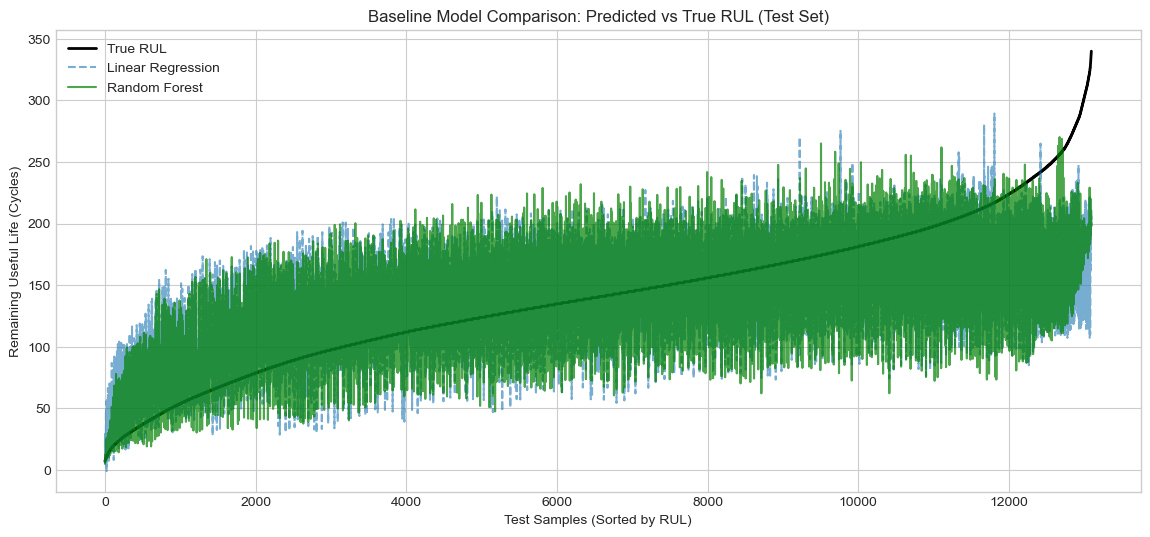

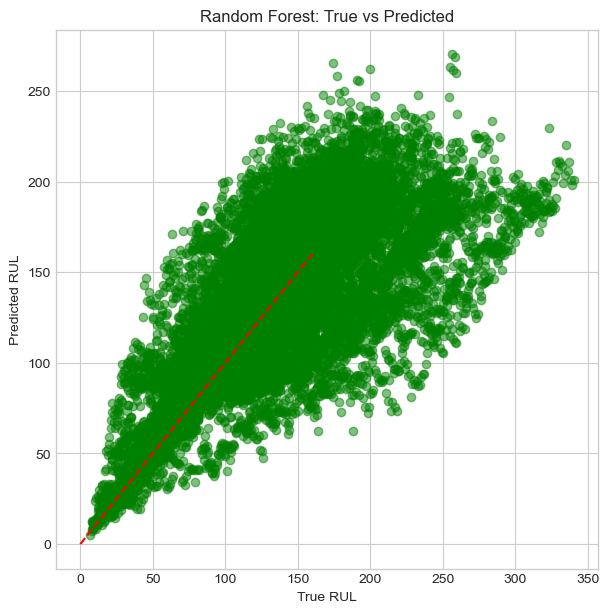

In [ ]:
# Comparison Dataframe
results = pd.DataFrame({
    'Metric': ['RMSE Train', 'RMSE Val', 'RMSE Test'],
    'Linear Regression': [rmse_train, rmse_val, rmse_test],
    'Random Forest': [rmse_train_rf, rmse_val_rf, rmse_test_rf]
})
print(results)

# Visualization: True vs Predicted RUL
plt.figure(figsize=(14, 6))

# Sort by True RUL for clearer visualization
sorted_idx = np.argsort(y_test)
plt.plot(y_test.iloc[sorted_idx].values, label='True RUL', color='black', linewidth=2)
plt.plot(y_pred_test[sorted_idx], label='Linear Regression', alpha=0.6, linestyle='--')
plt.plot(y_pred_test_rf[sorted_idx], label='Random Forest', alpha=0.7, color='green')

plt.title('Baseline Model Comparison: Predicted vs True RUL (Test Set)')
plt.xlabel('Test Samples (Sorted by RUL)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.show()

# Scatter Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test_rf, alpha=0.5, color='green')
plt.plot([0, 160], [0, 160], 'r--')
plt.title('Random Forest: True vs Predicted')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.grid(True)
plt.show()